<a href="https://colab.research.google.com/github/kunal-git-002/Detectron-2/blob/master/pt5_draw_the_lines.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# pt 5 : draw the lines from one kepoint to another

> for single person








# preavious data of part 4 


In [113]:
from google.colab.patches import cv2_imshow
import cv2
import pandas as pd

In [114]:

# install dependencies: 
!pip install pyyaml==5.1 pycocotools>=2.0.1
import torch, torchvision
print(torch.__version__, torch.cuda.is_available())
!gcc --version
# opencv is pre-installed on colab

1.6.0+cu101 True
gcc (Ubuntu 7.5.0-3ubuntu1~18.04) 7.5.0
Copyright (C) 2017 Free Software Foundation, Inc.
This is free software; see the source for copying conditions.  There is NO
warranty; not even for MERCHANTABILITY or FITNESS FOR A PARTICULAR PURPOSE.



In [115]:
# install detectron2: (Colab has CUDA 10.1 + torch 1.6)
# See https://detectron2.readthedocs.io/tutorials/install.html for instructions
assert torch.__version__.startswith("1.6")
!pip install detectron2 -f https://dl.fbaipublicfiles.com/detectron2/wheels/cu101/torch1.6/index.html

Looking in links: https://dl.fbaipublicfiles.com/detectron2/wheels/cu101/torch1.6/index.html


In [116]:
# Some basic setup:
# Setup detectron2 logger
import detectron2
from detectron2.utils.logger import setup_logger
setup_logger()

# import some common libraries
import numpy as np
import os, json, cv2, random
from google.colab.patches import cv2_imshow

# import some common detectron2 utilities
from detectron2 import model_zoo
from detectron2.engine import DefaultPredictor
from detectron2.config import get_cfg
from detectron2.utils.visualizer import Visualizer
from detectron2.data import MetadataCatalog, DatasetCatalog

In [117]:
def read_img(path):
  img=cv2.imread(path)
  h,w,ch=img.shape

  new_h=800
  ratio=h/new_h

  new_w=int(w/ratio)

  return cv2.resize(img,(new_w,new_h))

img = read_img("/content/drive/My Drive/imgs/st1.png")

#cv2_imshow(img)

In [118]:
# Inference with a keypoint detection model
cfg = get_cfg()
cfg.merge_from_file(model_zoo.get_config_file("COCO-Keypoints/keypoint_rcnn_R_50_FPN_3x.yaml"))
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.7  # set threshold for this model
cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url("COCO-Keypoints/keypoint_rcnn_R_50_FPN_3x.yaml")
predictor = DefaultPredictor(cfg)

outputs = predictor(img)#return a dictionaries

v = Visualizer(img[:,:,::-1], MetadataCatalog.get(cfg.DATASETS.TRAIN[0]), scale=1.2)
out = v.draw_instance_predictions(outputs["instances"].to("cpu"))

#cv2_imshow(out.get_image()[:, :, ::-1])

***step 1 : getting all the information***

In [119]:

ins=outputs["instances"]#create output instance

op_data=ins.get_fields()#this return a all the imp data like, bboxes,confidence score,keypoints locations & classes

keypoints_data=op_data["pred_keypoints"]

#conversion of data into numpy array

#data is first moved to cpu and then converted to numpy array
keypoints_data = keypoints_data.cpu().data.numpy()

#now numpy array
keypoints_data=keypoints_data=np.array(keypoints_data)

In [120]:
keypoints_data.shape

(1, 17, 3)

In [121]:
n,k,_=keypoints_data.shape
#n=num of instanves
#k=num of keypoints per instances
#_=3 ,becz we have three values (x,y,visbility)

#indexes of human keypoints according Detectron 2 keypoints model
human_keypoints={0: 'nose',
 1: 'left_eye',
 2: 'right_eye',
 3: 'left_ear',
 4: 'right_ear',
 5: 'left_shoulder',
 6: 'right_shoulder',
 7: 'left_elbow',
 8: 'right_elbow',
 9: 'left_wrist',
 10: 'right_wrist',
 11: 'left_hip',
 12: 'right_hip',
 13: 'left_knee',
 14: 'right_knee',
 15: 'left_ankle',
 16: 'right_ankle'}

all_kps={}

for i in range(n):
  kps=keypoints_data[i]

  temp_dic={}
  for j in range(len(kps)):

    x,y,vis=kps[j]
    #x,y,vis=int(x),int(y),int(vis)
    temp_dic[j]=(human_keypoints[j],
                 (x,y))
  
  all_kps[i]=temp_dic


convert into pandas dataframe

In [122]:

kps=[i for i in human_keypoints.values()]
keypoints_locs_df=pd.DataFrame(data=kps)
keypoints_locs_df.rename(columns={0:"human part"},inplace=True)

for ins in range(n):
  kps=all_kps[ins]
  temp_li=[]
  for ind,val in kps.items():
    part,locs=val
    temp_li.append(locs)
  keypoints_locs_df["person "+str(ins)+" (x,y)"]=temp_li

keypoints_locs_df.set_index("human part",drop=True)

,"person 0 (x,y)"
human part,
nose,"(350.08545, 101.575134)"
left_eye,"(361.48383, 87.5547)"
right_eye,"(334.3031, 88.43098)"
left_ear,"(383.40378, 95.44119)"
right_ear,"(317.64395, 98.07003)"
left_shoulder,"(428.12042, 184.82147)"
right_shoulder,"(283.44885, 191.83168)"
left_elbow,"(451.79398, 287.3459)"
right_elbow,"(253.63774, 289.97473)"


# draw the lines

> we dont consider left eye, right eye ,left ear & right ear point




***step 1 :find all points for draw lines***

In [123]:
line_points=[]
for col in keypoints_locs_df.columns[1:]: 

  for i in range(k):

      x,y=keypoints_locs_df[col][i]
      locs=(int(x),int(y))

      #cv2.circle(img,locs,2,(0,255,0),-1)

      if 0<i<5:#skiping the 1,2,3,4 point
        pass

      else:

        line_points.append(locs)


#for connecting 0 point & center of (7,8) point
#first we find center of (7,8)
x_,y_=(np.array(line_points[7])+np.array(line_points[8]))/2
x_,y_=int(x_),int(y_)



***step 2 : visulize the data on white frame***

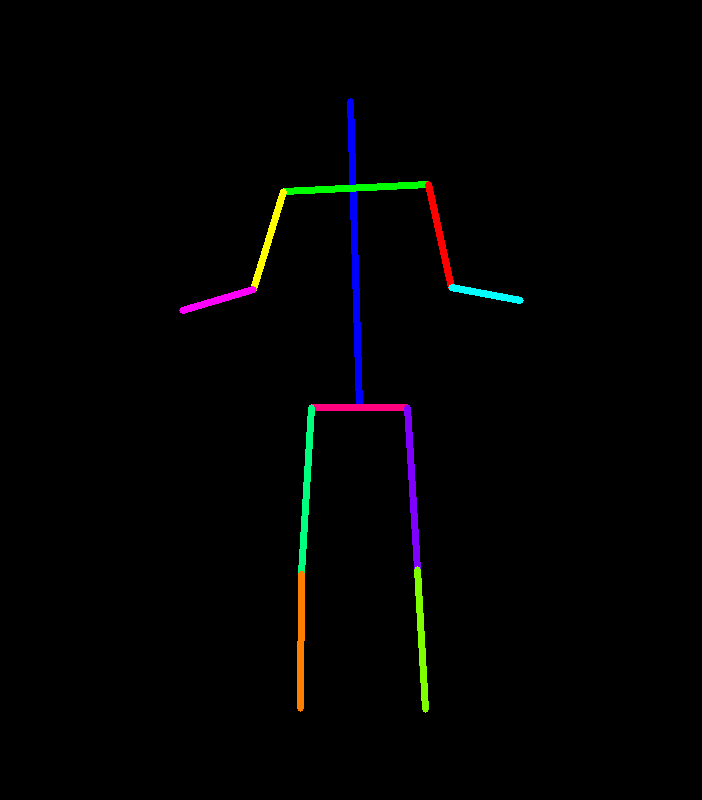

In [124]:
#colors for lines
colors=[(255,0,0),(0,255,0),(0,0,255),(255,255,0),(0,255,255),(255,0,255),(255,127,0),
        (255,0,127),(0,255,127),(127,255,0),(0,127,255),(127,0,255),(0,0,0)]

#thickness
thi=5

#we make new white frame for see only lines
white_frame=np.zeros(shape=img.shape,dtype=np.uint8)
fm=white_frame

for i in [0,1,2,7,8]:

  if i==0:

    cv2.line(fm,line_points[i],(x_,y_),colors[0],thi)#nose to center of right & left hip

  elif i==1:

    cv2.line(fm,line_points[i],line_points[i+1],colors[1],thi)#left shoulder to right shoulder 
    cv2.line(fm,line_points[i],line_points[i+2],colors[2],thi)#left shoulder to left elbow
    cv2.line(fm, line_points[i+2],line_points[i+4],colors[3],thi)#left elbow to left wrist

  elif i==2:

    cv2.line(fm,line_points[i],line_points[i+2],colors[4],thi)#right shoulder to right right elbow
    cv2.line(fm,line_points[i+2],line_points[i+4],colors[5],thi)#right elbow to right wrist

  elif i==7:

    cv2.line(fm,line_points[i],line_points[i+1],colors[11],thi)#left hip tp right hip
    cv2.line(fm,line_points[i],line_points[i+2],colors[7],thi)#left hip to left knee
    cv2.line(fm, line_points[i+2],line_points[i+4],colors[8],thi)#left knee to left ankle

  elif i==8:

    cv2.line(fm,line_points[i],line_points[i+2],colors[9],thi)#right hip to right knee
    cv2.line(fm,line_points[i+2],line_points[i+4],colors[10],thi)#right knee to right ankle


cv2_imshow(fm)